# Sensitivity, power, reproducibility

As we saw in the lecture, the concepts of sensitivity and power are concerned with controlling the rate of type I and type II errors respectively, where type I errors are false positives and type II errors are false negatives.

<img src="images/t1t2_error.png" width=80% >

Think about it this way:
* When we are talking about sensitivity (controlling type I errors) we are proposing that the true population effect is zero (say, correlation and we are interested in the probability of obtaining a certain value of a test statstistic (say, correlation r=0.25) due to chance.
* When we are talking about power (controlling type II errors) we are proposing that the true populaiton effect is non-zero (say correlation and we are interested in how frequently we fail to reject the null hypothesis.



### Set up Python libraries

As usual, run the code cell below to import the relevant Python libraries

In [1]:
# Set-up Python libraries - you need to run this but you don't need to change it
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import pandas 
import seaborn as sns

### Hypothetical example

Experiments in social psychology have been criticised for reporting implausibly large correlations based on small sample sizes. This caused quite a controversy a few years back and the debate on reproducibility continues on Twitter (I believe).

https://www.scientificamerican.com/article/brain-scan-results-overstated/

This issue is not specific to psychology, the same problem has been reported in other fields, such as genetics of disease. 

Let's consider a hypothetical case.

I conduct an experiment on <a href="https://en.wikipedia.org/wiki/Risk_aversion">risk aversion</a> in 50 participants, looking at how much money they are prepared to stake on a gamble in order to win a larger amount. 

<img src="images/roulette.png" width=50% >

For each participant I also obtain a trait anxiety measure based on a questionairre.

Then I calculate the correlation coefficient, Pearson's r, between trait anxiety and risk aversion across my sample of 50 participants.

* I observe a correlation of r=0.25 

Can I trust this result? 

### Eyeballing the data

What does a correlation of 0.25 look like for 50 data points?
Here are some examples of datasets that actually have r=0.25:

<img src="images/r25_examples.png" width=100% >

Would you trust those correlations?

## Specificity

A Type 1 error occurs when the null hypothesis is true (as it is for our simulated population with zero correlation), but is nonetheless rejected.

The specificity of a test is the probability of avoiding a Type 1 Error, if the null is true. So say the null hypothesis is true and we test at the $\alpha$=0.05 level. The probability of a Type 1 error is (by definition) 5% and the specificity of the test is 95%.

In this section we check that we do indeed get a false positive (ie a Type 1 error) 5% of the time when testing at the $\alpha$=0.05 level in a population here the null is true. 

#### Our example:

* $\mathcal{H_0}$ Under the null hypothesis there is no correlation between anxiety scores and rish aversion
* $\mathcal{H_a}$ Under the alternative hypothesis, there is a correlation

Let's start by generating a large dataset with 25000 pairs in it (so 2 columns, 25000 rows), with a correlation between columns of zero. Don't worry too much about this code block as you will not be asked to replicate this by yourself.

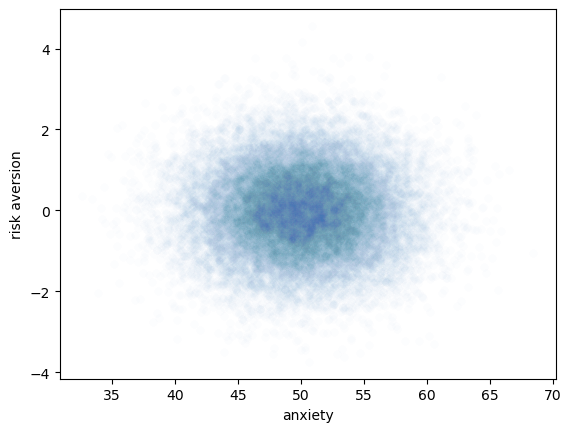

In [2]:
# Code to generate the population with zero correlation - don't worry about understanding this bit

rho=0 # the desired correlation

# desired mean and sd of variables in columns 0 and 1
m0=50
m1=0
s0=4.5
s1=1

c=[[1,rho],[rho,1]] # the correlation matrix that we want in the simulated dataset

# make two columns of numbers with the desired correlation (mean of each column is zero, sd is 1)
tmp=np.random.multivariate_normal([0,0],c,size=25000)

# scale the variables to get correct mean and sd
tmp[:,0]=(tmp[:,0]*s0)+m0
tmp[:,1]=(tmp[:,1]*s1)+m1
pop_rZero=pandas.DataFrame(tmp,columns=['anxiety','risk aversion'])

# plot scatterplot
sns.scatterplot(data=pop_rZero,x='anxiety',y='risk aversion',alpha=0.01)
plt.show()

The generated dataset has two columns and 25,000 rows. 

The correlation between the two columns should be close to the <tt>r</tt> value we set, ie zero. 

The scatterplot definitely looks like there is no correlation!

In [3]:
# check that the actual correlation is in the 10000 simulated samples
pop_rZero.corr()

,anxiety,risk aversion
anxiety,1.000000,-0.006784
risk aversion,-0.006784,1.000000


### Specificity or probability of a Type 1 error

A Type 1 error occurs when the null hypothesis is true (as it is for our simulated population with zero correlation), but is nonetheless rejected.

If I choose an alpha value of 0.05, this means I would reject the null hypothesis if the $p$-value for my obtained correlation is less than 0.05.

By definition, for random samples from a population with no correlation, this should happen 5% of the time.

#### How to we get the p-value for a correlation?

For a given values of Pearson's $r$, we can work out a t-score using the equation:

$$ t=\frac{r}{\sqrt{(1-r^2)(n-2)}} $$

and then the p value is obtained from the $t_{n-2}$ distribution.

However you can get straight to the $p$-value by using <tt>scipy.stats</tt> - note that we are using <tt>scipy.stats</tt> as the other correlation functions we met in <tt>numpy</tt> and <tt>pandas</tt> do not return a $p$-value.

For example:

In [4]:
sample = pop_rZero.sample(n=50)
stats.pearsonr(sample['anxiety'], sample['risk aversion'])

PearsonRResult(statistic=0.11994144059194592, pvalue=0.4067287974607673)

... and to return just the p-value as a single number:

In [5]:
res = stats.pearsonr(sample['anxiety'], sample['risk aversion'])
res.pvalue

0.4067287974607673

#### Back to probability of a Type 1 errror

Let's try drawing 10000 samples from our no-correlation population and see how often we do get a significant result!

In [6]:
nReps=10000
sampleSize=50
p = np.empty(nReps)

for i in range(nReps):
    sample = pop_rZero.sample(n=sampleSize)
    res = stats.pearsonr(sample['anxiety'], sample['risk aversion'])
    p[i] = res.pvalue
    
# How many of our 10000 sammples had p<0.05?
np.mean(p<0.05)

0.0564

Hopefully the proportion of samples from the no-correlation distribution with p<0.05 is about.... 0.05. 

## Power

A Type 2 error occurs hen the alternative hypothesis is true, but we fail to reject the null.

The probability of correctly rejecting the null when $\mathcal{H_a}$ is true is the sensitivity or power of a test. So if the probability of a Type 2 error for a given test is 20%, the sensitivity or power of the test is 80%.

### Power by simulation

We can investigate power in our correlation example using the same simulation approach as above, but now we need to <i>assume the true population correlation $\rho$ is 0.25<i>

First, I'm going to generate a population (25 000 pairs of values) in which the true correlation between two variables (let's call them 'anxiety' and 'risk aversion') is 0.25. Again don't worry too much about understanding this code block.

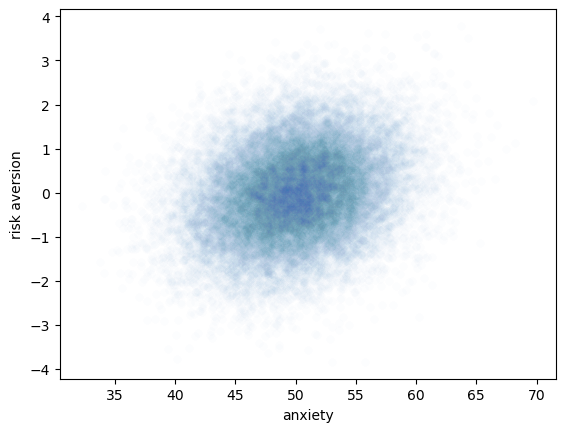

In [7]:
# Code to generate the population with a correlation of rho - don't worry about understanding this bit

rho=0.25 # the desired correlation

# desired mean and sd of variables in columns 0 and 1
m0=50
m1=0
s0=4.5
s1=1

c=[[1,rho],[rho,1]] # the correlation matrix that we want in the simulated dataset

# make two columns of numbers with the desired correlation (mean of each column is zero, sd is 1)
tmp=np.random.multivariate_normal([0,0],c,size=25000)

# scale the variables to get correct mean and sd
tmp[:,0]=(tmp[:,0]*s0)+m0
tmp[:,1]=(tmp[:,1]*s1)+m1
pop_rNonZero=pandas.DataFrame(tmp,columns=['anxiety','risk aversion'])

# plot scatterplot
sns.scatterplot(data=pop_rNonZero,x='anxiety',y='risk aversion',alpha=0.01)
plt.show()

Hopefully the scatterplot shows some data with a weak correlation (the datapoints are no longer spread on a circle, but stretched into an oval shape). 

We can check the correlation in the full population of 25000 samples, hopefully this should be close to 0.25.

In [8]:
pop_rNonZero.corr()

,anxiety,risk aversion
anxiety,1.000000,0.251163
risk aversion,0.251163,1.000000


The question for our *power analysis* is, for samples of size n=50, what proportion of the time will I obtain a significant correlation (reject the null)?

To answer that question I am going to draw samples of size 50 from the population *which actually has $r$=0.25* and obtain the sample correlation for each of those samples and its p value using <tt>scipy.stats</tt>. I can then ask in what proportion of simulated samples $p<0.05$, ie in what proportion of the simulated samples we manage to reject the null.

In [9]:
nReps=1000
sampleSize=50
p = np.empty(nReps)

for i in range(nReps):
    sample = pop_rNonZero.sample(n=sampleSize)
    res = stats.pearsonr(sample['anxiety'], sample['risk aversion'])
    p[i] = res.pvalue
    
# How many of our 10000 samples had p<0.05?
np.mean(p<0.05)

0.422

In my simulation I manage to reject the null is 41% of simulations. SO my test has a power of 41%


<img src="images/Minion_what.jpg" width=15% >

Yes, that's right. In a population where the *true* correlation between two variables (anxiety and risk aversion) is 0.25, for samples of size 50, I will fail to detect a significant correlation (ie, I will make a Type 2 error) over half the time.

## Sample size

#### The probability of a Type 1 error does not depend on sample size

Statistical tests are designed to control the probability of a type 1 error. When calculating the critical value of the test statistic (in the case of correlation, the test statistic is $r$ and the critical value is minimum $r$ value that would be considered significant for a given sample size $n$, $n$ is directly taken into account. Therefore, the probably of a type 1 error is fixed regardless of sample size.

#### The probability of a Type 1 error *does* not depend on sample size

The above is *not* true for type 2 error. The probability of Type 2 error (and hence the power of the test) varies with sample size.

If we increase the sample size, the power of the test increases.

Let's try it! Change the sample size in the code block below to 10,100 and 1000. How does the power change


In [10]:
nReps=1000
sampleSize=50
p = np.empty(nReps)

for i in range(nReps):
    sample = pop_rNonZero.sample(n=sampleSize)
    res = stats.pearsonr(sample['anxiety'], sample['risk aversion'])
    p[i] = res.pvalue
    
# How many of our 10000 samples had p<0.05?
print('power = ' + str(100*(np.mean(p<0.05))) + '%')

power = 42.9%


We can loop over different sample sizes and plot how power increases as sample size increases:

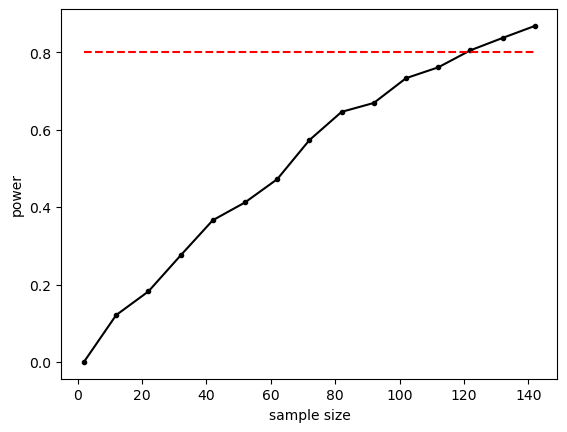

In [11]:
n=range(2,150,10)
power = np.empty(len(n))

for s in range(len(n)):
    nReps=1000
    p = np.empty(nReps)
    sampleSize=n[s]

    for i in range(nReps):
        sample = pop_rNonZero.sample(n=sampleSize)
        res = stats.pearsonr(sample['anxiety'], sample['risk aversion'])
        p[i] = res.pvalue
    
    power[s]=np.mean(p<0.05)
    
# plot the results
plt.plot(n,power,'k.-')
plt.plot([min(n),max(n)],[0.8,0.8],'r--') # reference line for 80% power
plt.xlabel('sample size')
plt.ylabel('power')
plt.show()

The relationship between sample size and power is slightly bumpy as we checked only 1000 simulated samples at each sample size. If you increased nReps to 10,000 the curve would look smoother (but the simulation ould take a long time to run).

Conventionally a power of 80% (indicated by the red dashed line on the graph) is considered desirable. What sample size do we need to get power of 80%? It looks from the graph like you would need around n=120. Let's re-run a finer grained simulation in that range:



In [12]:
n=range(120,130)
power = np.empty(len(n))

for s in range(len(n)):
    nReps=100000
    p = np.empty(nReps)
    sampleSize=n[s]

    for i in range(nReps):
        sample = pop_rNonZero.sample(n=sampleSize)
        res = stats.pearsonr(sample['anxiety'], sample['risk aversion'])
        p[i] = res.pvalue
    
    power[s]=np.mean(p<0.05)
    
plt.plot(n,power,'k.-')
plt.plot([min(n),max(n)],[0.8,0.8],'r--') # reference line for 80% power
plt.xlabel('sample size')
plt.ylabel('power')
plt.xticks(range(min(n),max(n),5))
plt.show()

KeyboardInterrupt: 

### Power in practice

Power is defined as the proportion of the time we would expect to get a statistically significant effect in samples of size $n$, given that there is a true effect of a certain size (for example $r$=0.25) in the population. 

An obvious problem with this is that in a real experiment you wouldn't know the true effect sizze in the underlying population - that is what you are trying to measure! So how can you calculate the power for a given planned sample size, or the sample size needed to achieve 80% power, in advance? 

The honest answer is that often this is not possible. Sometimes we can estimate the effect size (such as the correlation in the underlying population) fromm looking at similar studies in the literature, but usually such guesses will give only a very rough estimate of the effect size that will arise in our planned experiment.


### Clinically significant effect size

One context in which power can definitely be meaningfully defined, is when we kno hat size of effect we would *car about*, even if we don't know hat the underlying effect sizze in the population is. 

Say for example we are testing a new analgesic drug. We may not kno how much the drug will ruduce pain scores (the true effect sizze) but we can certainly define a minimum effect size that would be clinically meaningful You could say that you would only consider the effect of the drug clinically significant if there is a 10% change in pain scores (otherwise, the drug won't be worth taking). That is different from statstistical significance - if you test enough patients you could detect a statstically significant result even for a very small change in clinical outcome but it still wouldn't mean your drug is an effective painkiller.

If we conduct a power analysis assuming that the effect size in the population is the minimmum clincally significant effect, this will tell us how many participants we need to detect such a clinically significant effect with (say) 80% power. By definition a smaller effect would need more participants to detect it (but we wouldn't be interested in such a small effect from a clinical persoective, so that doesn't matter). Any effect larger than the minimum clinically significant effect ould have more than 80% power, as larger effects are easier to detect.